# Using Fast Downward in the Unified Planning Library

In [1]:
!pip install --pre unified-planning
!pip install up_fast_downward

In [2]:
!pip install matplotlib # for visualisation in this notebook

In [3]:
import sys
import unified_planning as up
import up_fast_downward
from unified_planning.shortcuts import *

## A simple example planning task

For illustration purposes, we randomly generate a planning task, where a single truck without capacity limit has to deliver a number of parcels between the locations of a graph.

Jobs:
Parcel 0 from location 11 to location 3
Parcel 1 from location 0 to location 6
Parcel 2 from location 9 to location 10
Parcel 3 from location 8 to location 0
Parcel 4 from location 5 to location 13
Parcel 5 from location 8 to location 9
Parcel 6 from location 5 to location 11
Parcel 7 from location 5 to location 14
Parcel 8 from location 4 to location 6
Parcel 9 from location 0 to location 2
Parcel 10 from location 14 to location 5
Parcel 11 from location 5 to location 6
Parcel 12 from location 7 to location 13
Parcel 13 from location 6 to location 8
Parcel 14 from location 12 to location 5
Parcel 15 from location 12 to location 6
Parcel 16 from location 8 to location 13
Parcel 17 from location 3 to location 2
Parcel 18 from location 12 to location 11
Parcel 19 from location 6 to location 4
Parcel 20 from location 5 to location 3
Parcel 21 from location 8 to location 3
Parcel 22 from location 7 to location 11
Parcel 23 from location 2 to location 8
Parcel 24 from location 0 to lo

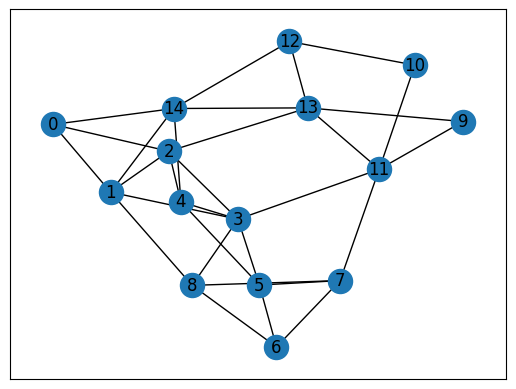

In [4]:
import networkx as nx
import matplotlib # uncomment if not available
import random

def generate_problem(num_locations, num_parcels):
    # generate a random connected graph with the locations 
    graph = nx.connected_watts_strogatz_graph(num_locations, 4, 0.2)

    # randomly choose the origin and destination of every parcel
    jobs = []
    for parcel in range(num_parcels):
        origin = random.randrange(num_locations) 
        destination = random.choice([x for x in range(num_locations)
                                     if x != origin])
        jobs.append((origin, destination))


    # randlomly choose a truck location
    truck_location = random.randrange(num_locations)
    return graph, jobs, truck_location

num_locations = 15
num_parcels = 25
graph, jobs, truck_location = generate_problem(num_locations, num_parcels)

nx.draw_networkx(graph, with_labels=True) # uncomment if you do not have matplotlib
print("Jobs:")
for parcel_id, (origin, destination) in enumerate(jobs):
    print('Parcel', parcel_id, 'from location', origin,
          'to location', destination) 
print('The truck is at location', truck_location)

The possible actions in the planning task are to move the truck from one location to a connected location, to load a parcel (if the truck is at the same location) and to unload the parcel at its destination location.

We use a unary predicate ``truck_at`` and a binary predicate ``parcel_at``, to represent the locations of the truck and all parcels. Unary predicates ``parcel_loaded`` and ``delivered`` express that a parcel is in the truck or has been delivered. The destinations of the parcels are represented with binary predicate ``destination`` and the connections (edges) with binary predicate ``connected``.

In [5]:
def get_planning_task(graph, jobs, truck_location):
    num_parcels = len(jobs)
    num_locations = len(graph)
    # declare user types
    Location = UserType('Location')
    Parcel = UserType('Parcel')

    # declare predicates
    truck_at = up.model.Fluent('truck_at', BoolType(), l=Location)
    parcel_at = up.model.Fluent('parcel_at', BoolType(), p=Parcel, l=Location)
    parcel_loaded = up.model.Fluent('parcel_loaded', BoolType(), p=Parcel)
    delivered = up.model.Fluent('delivered', BoolType(), p=Parcel)
    destination = up.model.Fluent('destination', BoolType(), p=Parcel, l=Location)
    connected = up.model.Fluent('connected', BoolType(), l_from=Location, l_to=Location)

    # add (typed) objects to problem
    problem = up.model.Problem('parcels')
    locations = [up.model.Object('loc%s' % i, Location)
                 for i in range(num_locations)]
    parcels = [up.model.Object('parcel%s' % i, Parcel)
               for i in range(num_parcels)]
    problem.add_objects(locations)
    problem.add_objects(parcels)

    # specify the initial state
    problem.add_fluent(truck_at, default_initial_value=False)
    problem.add_fluent(parcel_at, default_initial_value=False)
    problem.add_fluent(parcel_loaded, default_initial_value=False)
    problem.add_fluent(delivered, default_initial_value=False)
    problem.add_fluent(destination, default_initial_value=False)
    problem.add_fluent(connected, default_initial_value=False)
    for parcel_id, (origin, dest) in enumerate(jobs):
        p = parcels[parcel_id]
        problem.set_initial_value(parcel_at(p, locations[origin]), True)
        problem.set_initial_value(destination(p, locations[dest]), True)
    for (l1, l2) in graph.edges():
        problem.set_initial_value(connected(locations[l1], locations[l2]), True)
        problem.set_initial_value(connected(locations[l2], locations[l1]), True)
    problem.set_initial_value(truck_at(locations[truck_location]), True)

    # add actions
    move = up.model.InstantaneousAction('move', l_from=Location, l_to=Location)
    l_from = move.parameter('l_from')
    l_to = move.parameter('l_to')
    move.add_precondition(connected(l_from, l_to))
    move.add_precondition(truck_at(l_from))
    move.add_effect(truck_at(l_from), False)
    move.add_effect(truck_at(l_to), True)
    problem.add_action(move)

    load = up.model.InstantaneousAction('load', p=Parcel, l=Location)
    p = load.parameter('p')
    loc = load.parameter('l')
    load.add_precondition(truck_at(loc))
    load.add_precondition(parcel_at(p, loc))
    load.add_effect(parcel_at(p, loc), False)
    load.add_effect(parcel_loaded(p), True)
    problem.add_action(load)

    unload = up.model.InstantaneousAction('unload', p=Parcel, l=Location)
    p = unload.parameter('p')
    loc = unload.parameter('l')
    unload.add_precondition(truck_at(loc))
    unload.add_precondition(parcel_loaded(p))
    unload.add_precondition(destination(p, loc))
    unload.add_effect(delivered(p), True)
    unload.add_effect(parcel_loaded(p), False)
    problem.add_action(unload)

    # specify the goal: all parcels should have been delivered
    for parcel_id, _ in enumerate(jobs):
        p = parcels[parcel_id]
        problem.add_goal(delivered(p))

    # we only want to minimize the number of actions
    problem.add_quality_metric(MinimizeSequentialPlanLength())
    return problem

problem = get_planning_task(graph, jobs, truck_location)

## Solving the task

### Quickly solving the task

If we do not necessarily need an optimal plan (with respect to the metric specified in the task), we can use ``fast-downward`` in the oneshot operation mode. This is usually faster than seeking an optimal solution.

In [6]:
with OneshotPlanner(name='fast-downward') as planner:
    result = planner.solve(problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Fast Downward returned %s" % result.plan)
    else:
        print("No plan found.")

NOTE: To disable printing of planning engine credits, add this line to your code: `up.shortcuts.get_environment().credits_stream = None`
  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `/tmp/ipykernel_345780/2241635372.py`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.

Fast Downward returned SequentialPlan:
    load(parcel0, loc11)
    move(loc11, loc3)
    load(parcel17, loc3)
    unload(parcel0, loc3)
    move(loc3, loc4)
    load(parcel8, loc4)
    move(loc4, loc14)
    load(parcel10, loc14)
    move(loc14, loc0)
    load(parcel9, loc0)
    load(parcel24, loc0)
    load(parcel1, loc0)
    move(loc0, loc2)
    unload(parcel9, loc2)
    load(parcel23, loc2)
    unload(parcel17, loc2)
    move(loc2, loc13)
    move(loc13, loc11)
    move(loc11,

In [7]:
# We do not want to see the credits again and again, so let's disable them from now on.
up.shortcuts.get_environment().credits_stream = None

### Solving the task optimally (and using the ActionCostMetric)

Solving a task optimally can take substantially more time (intuitively, we do not only need to find a plan but also have to exclude that any other action sequence provides a better solution). Let's thus use a smaller example with 10 locations and 8 parcels. To make it a bit more interesting, we use operator costs and make some connections more expensive to travel.

In [8]:
graph, jobs, truck_location = generate_problem(10, 8)
small_problem = get_planning_task(graph, jobs, truck_location)

expensive_edges = random.sample(list(graph.edges), 6)
Location = small_problem.user_type("Location")
move_cost = up.model.Fluent("move_cost", IntType(), from_loc=Location, to_loc=Location)
small_problem.add_fluent(move_cost, default_initial_value=Int(1))
for l1, l2 in expensive_edges:
    loc1 = small_problem.object("loc%s" % l1)
    loc2 = small_problem.object("loc%s" % l2)
    small_problem.set_initial_value(move_cost(loc1, loc2), Int(3))
    small_problem.set_initial_value(move_cost(loc2, loc1), Int(3))

move = small_problem.action("move")
m = MinimizeActionCosts({move : move_cost(move.l_from, move.l_to)}, default=Int(1))
small_problem.clear_quality_metrics()
small_problem.add_quality_metric(m)

If we require an optimal plan, we can use the engine ``fast-downward-opt``. Note that you also see the optimality guarantee reflected in the result status.

In [9]:
with OneshotPlanner(name='fast-downward-opt') as planner:
    result = planner.solve(small_problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_OPTIMALLY:
        print("I found the following optimal", result.plan)
    else:
        print("No plan found.")

I found the following optimal SequentialPlan:
    load(parcel1, loc9)
    move(loc9, loc5)
    load(parcel6, loc5)
    move(loc5, loc4)
    move(loc4, loc3)
    load(parcel5, loc3)
    load(parcel3, loc3)
    move(loc3, loc7)
    unload(parcel6, loc7)
    unload(parcel1, loc7)
    load(parcel0, loc7)
    move(loc7, loc8)
    unload(parcel5, loc8)
    move(loc8, loc0)
    load(parcel7, loc0)
    load(parcel2, loc0)
    move(loc0, loc1)
    load(parcel4, loc1)
    unload(parcel0, loc1)
    move(loc1, loc9)
    unload(parcel4, loc9)
    unload(parcel3, loc9)
    unload(parcel2, loc9)
    move(loc9, loc5)
    move(loc5, loc6)
    unload(parcel7, loc6)


### Anytime mode: Finding better and better solutions

The anytime operation mode returns found plans as intermediate results but continues searching for better plans. This might be a good option if you are interested in "the best plan you can find within the available time".

(Solve the larger ``problem`` if you want to observe it continuing the search.)

In [10]:
problem_to_solve = small_problem # you can try it on "problem" here

# We will use a plan validator to determine the plan costs for the output:
pv = PlanValidator(problem_kind=problem_to_solve.kind)
metric = problem_to_solve.quality_metrics[0]

# Let's start the planner
with AnytimePlanner(name='fast-downward') as planner:
    for result in planner.get_solutions(problem_to_solve): 
        if result.status == up.engines.PlanGenerationResultStatus.INTERMEDIATE:
            pv_res = pv.validate(problem_to_solve, result.plan)
            print("Found an intermediate plan of cost", pv_res.metric_evaluations[metric])
            print("Continue searching...")
        elif result.status in (up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING,
                               up.engines.PlanGenerationResultStatus.SOLVED_OPTIMALLY):
            pv_res = pv.validate(problem_to_solve, result.plan)
            print("The final plan has cost", pv_res.metric_evaluations[metric])
            print(result.plan)
        else:
            print("No plan found.")


Found an intermediate plan of cost 38
Continue searching...
Found an intermediate plan of cost 37
Continue searching...
Found an intermediate plan of cost 36
Continue searching...
Found an intermediate plan of cost 35
Continue searching...
Found an intermediate plan of cost 34
Continue searching...
Found an intermediate plan of cost 32
Continue searching...
Found an intermediate plan of cost 31
Continue searching...
Found an intermediate plan of cost 30
Continue searching...
Found an intermediate plan of cost 29
Continue searching...
Found an intermediate plan of cost 28
Continue searching...
The final plan has cost 28
SequentialPlan:
    load(parcel1, loc9)
    move(loc9, loc5)
    load(parcel6, loc5)
    move(loc5, loc4)
    move(loc4, loc3)
    load(parcel5, loc3)
    load(parcel3, loc3)
    move(loc3, loc7)
    unload(parcel6, loc7)
    unload(parcel1, loc7)
    load(parcel0, loc7)
    move(loc7, loc8)
    unload(parcel5, loc8)
    move(loc8, loc0)
    load(parcel7, loc0)
    load(

### Advanced: Using alternative configurations

If you call the planner as seen in the previous examples, we use some predefined default configurations, which work well in general. This does not mean that it is the best possible configuration for your problem at hand and Fast Downward has a large number of heuristics and strategies implemented. For the details we refer to the documentation at the [Fast Downward homepage](https://www.fast-downward.org/). You can use all translator and search configurations also through the unified planning framework.

##### Using a planner alias

For some common configurations (that have participated in the international planning competition), Fast Downward provides short [aliases](https://www.fast-downward.org/IpcPlanners). You can specify them with the parameters ``fast_downward_alias`` (used for oneshot planning) and ``fast_downward_anytime_alias`` (used in anytime mode).

In this example, we use the portfolio configuration ``seq-sat-fdss-2`` for solving the task in anytime mode. Such portfolio configurations are mostly intended for solving harder tasks and distribute the overall time among several subconfigurations. For this reason they require a search time limit, which we also provide. Note that the built-in portfolios are optimized for the 30 minutes time limit used in the planning competition (permitting significant precomputation), so not all of them will work well with short time limits.

In [11]:
params = {
    'fast_downward_anytime_alias': 'seq-sat-fdss-2',
    'fast_downward_search_time_limit': "20s"
}

with AnytimePlanner(name='fast-downward', params=params) as planner:
    for result in planner.get_solutions(small_problem): # you can try it on "problem" here
        if result.status == up.engines.PlanGenerationResultStatus.INTERMEDIATE:
            print("Found an intermediate plan of length:", len(result.plan.actions))
            print("Continue searching...")
        elif result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
            print("The final plan has length:", len(result.plan.actions))
            print(result.plan)
        else:
            print("No plan found.")

Found an intermediate plan of length: 30
Continue searching...
Found an intermediate plan of length: 35
Continue searching...
The final plan has length: 35
SequentialPlan:
    load(parcel1, loc9)
    move(loc9, loc1)
    load(parcel4, loc1)
    move(loc1, loc9)
    unload(parcel4, loc9)
    move(loc9, loc8)
    move(loc8, loc7)
    unload(parcel1, loc7)
    load(parcel0, loc7)
    move(loc7, loc8)
    move(loc8, loc9)
    move(loc9, loc1)
    unload(parcel0, loc1)
    move(loc1, loc9)
    move(loc9, loc5)
    load(parcel6, loc5)
    move(loc5, loc9)
    move(loc9, loc8)
    move(loc8, loc7)
    unload(parcel6, loc7)
    move(loc7, loc3)
    load(parcel5, loc3)
    load(parcel3, loc3)
    move(loc3, loc2)
    move(loc2, loc0)
    load(parcel7, loc0)
    load(parcel2, loc0)
    move(loc0, loc8)
    unload(parcel5, loc8)
    move(loc8, loc6)
    unload(parcel7, loc6)
    move(loc6, loc5)
    move(loc5, loc9)
    unload(parcel3, loc9)
    unload(parcel2, loc9)


#### Using translator options and search configurations

Instead of using a preset alias, we can also run Fast Downward with any configuration from it configuration space. Internally Fast Downward first translates the task to a normalized Finite Domain Representation and afterwards runs the search.

There are not too many options for the translator component, as you can see from its (internal) documentation:
```
usage: translate.py [-h] [--relaxed] [--full-encoding]
                    [--invariant-generation-max-candidates INVARIANT_GENERATION_MAX_CANDIDATES]
                    [--sas-file SAS_FILE]
                    [--invariant-generation-max-time INVARIANT_GENERATION_MAX_TIME]
                    [--add-implied-preconditions] [--keep-unreachable-facts]
                    [--skip-variable-reordering] [--keep-unimportant-variables]
                    [--dump-task] [--layer-strategy {min,max}]
                    domain task
```

In the UP, you can set these options via the parameter ``fast_downward_translate_options``.

The configuration space for the search component is much larger and can can be set with ``fast_downward_search_config`` (for oneshot planning) and ``fast_downward_anytime_search_config`` (for anytime planning) respectively.

For an example, we stick to propsitional variables in the translator (skipping the invariant synthesis by setting the number of candidates to 0) and run an [eager greedy best-first search](https://www.fast-downward.org/Doc/SearchEngine#Greedy_search_.28eager.29) with the [FF heuristic](https://www.fast-downward.org/Doc/Evaluator#FF_heuristic) (both for heuristic guidance and preferred operators).

In [12]:
params = {
    'fast_downward_translate_options': ['--invariant-generation-max-candidates', '0'],
    'fast_downward_search_config': 'let(hff,ff(),eager_greedy([hff],preferred=[hff]))'
}

with OneshotPlanner(name='fast-downward', params=params) as planner:
    result = planner.solve(problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Found an plan of length:", len(result.plan.actions))

        print(result.plan)
    else:
        print("No plan found.")


Found an plan of length: 107
SequentialPlan:
    load(parcel0, loc11)
    move(loc11, loc3)
    load(parcel17, loc3)
    unload(parcel0, loc3)
    move(loc3, loc2)
    load(parcel23, loc2)
    unload(parcel17, loc2)
    move(loc2, loc4)
    load(parcel8, loc4)
    move(loc4, loc2)
    move(loc2, loc13)
    move(loc13, loc9)
    load(parcel2, loc9)
    move(loc9, loc11)
    move(loc11, loc10)
    unload(parcel2, loc10)
    move(loc10, loc12)
    load(parcel18, loc12)
    load(parcel15, loc12)
    load(parcel14, loc12)
    move(loc12, loc10)
    move(loc10, loc11)
    unload(parcel18, loc11)
    move(loc11, loc7)
    load(parcel22, loc7)
    load(parcel12, loc7)
    move(loc7, loc11)
    unload(parcel22, loc11)
    move(loc11, loc13)
    unload(parcel12, loc13)
    move(loc13, loc14)
    load(parcel10, loc14)
    move(loc14, loc0)
    load(parcel9, loc0)
    move(loc0, loc2)
    unload(parcel9, loc2)
    move(loc2, loc3)
    move(loc3, loc8)
    load(parcel5, loc8)
    load(parcel3, loc8

### Troubleshooting

If the planner does not behave at expected, you can inspect its log. You can access it via the ``output_stream`` parameter of ``solve``. You can also set the log level with ``log_level`` in the constructor (possible values are ``debug``, ``info`` (default) and ``warning``).

In [13]:
with OneshotPlanner(name='fast-downward', params={'log_level': 'info'}) as planner:
    result = planner.solve(problem, output_stream=sys.stdout)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Fast Downward returned: %s" % result.plan)
    else:
        print("No plan found.")

INFO     planner time limit: None
INFO     planner memory limit: None

INFO     Running translator.
INFO     translator stdin: None
INFO     translator time limit: None
INFO     translator memory limit: None
INFO     translator command line string: /home/roeger/repos/downward/up-fast-downward-env/bin/python3 /home/roeger/repos/downward/up-fast-downward/up_fast_downward/downward/builds/release/bin/translate/translate.py /tmp/tmp5aaln_u4/domain.pddl /tmp/tmp5aaln_u4/problem.pddl --sas-file output.sas
Parsing...
Parsing: [0.000s CPU, 0.001s wall-clock]
Normalizing task... [0.000s CPU, 0.000s wall-clock]
Instantiating...
Generating Datalog program... [0.000s CPU, 0.000s wall-clock]
Normalizing Datalog program...
Normalizing Datalog program: [0.000s CPU, 0.001s wall-clock]
Preparing model... [0.000s CPU, 0.001s wall-clock]
Generated 14 rules.
Computing model... [0.000s CPU, 0.001s wall-clock]
406 relevant atoms
180 auxiliary atoms
586 final queue length
632 total queue pushes
Completing ins

The output that you just have seen (hopefully) does not contain any errors. Let's create an actual issue. The heuristic used by the *optimal* engine does not support all features you can model in the unified planning library. Have a look at the goal specification of the problem:

In [14]:
print(small_problem.goals)

[delivered(parcel0), delivered(parcel1), delivered(parcel2), delivered(parcel3), delivered(parcel4), delivered(parcel5), delivered(parcel6), delivered(parcel7)]


We listed all parcels and required for each individual one that it has been delivered. Instead, we could use a quantified condition, expressing that all parcels should be delivered. Let's make this modification to the problem.

In [15]:
small_problem.clear_goals()
p = up.model.Variable("parcel", small_problem.user_type("Parcel"))
delivered = small_problem.fluent("delivered")
small_problem.add_goal(Forall(delivered(p), p))
print(small_problem.goals)

[Forall (Parcel parcel) delivered(parcel)]


This modified problem cannot be solved with the optimal engine:

In [16]:
with OneshotPlanner(name='fast-downward-opt') as planner:
    result = planner.solve(small_problem, output_stream=sys.stdout)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_OPTIMALLY:
        print("Fast Downward returned: %s" % result.plan)
    else:
        print(result.status)
        print("No plan found.")

INFO     planner time limit: None
INFO     planner memory limit: None

INFO     Running translator.
INFO     translator stdin: None
INFO     translator time limit: None
INFO     translator memory limit: None
INFO     translator command line string: /home/roeger/repos/downward/up-fast-downward-env/bin/python3 /home/roeger/repos/downward/up-fast-downward/up_fast_downward/downward/builds/release/bin/translate/translate.py /tmp/tmpdjwibkju/domain.pddl /tmp/tmpdjwibkju/problem.pddl --sas-file output.sas
Parsing...
Parsing: [0.000s CPU, 0.002s wall-clock]
Normalizing task... [0.000s CPU, 0.000s wall-clock]
Instantiating...
Generating Datalog program... [0.000s CPU, 0.000s wall-clock]
Normalizing Datalog program...
Trivial rules: Converted to facts.
Normalizing Datalog program: [0.000s CPU, 0.001s wall-clock]
Preparing model... [0.000s CPU, 0.001s wall-clock]
Generated 15 rules.
Computing model... [0.000s CPU, 0.001s wall-clock]
202 relevant atoms
94 auxiliary atoms
296 final queue length
334

We see that the ``result.status`` is ``PlanGenerationResultStatus.INTERNAL_ERROR``. Looking at the log, we see that we ``Tried to use unsupported feature``. The sentence ``This configuration does not support axioms!`` indicates the details but these are admittedly not obvious (Fast Downward internally replaces all-quantified goals with axioms).

To nevertheless use the optimal engine on this task, we can combine it with a compiler from the unified planning library, which removes quantifications:

In [17]:
with Compiler(
        problem_kind = small_problem.kind, 
        compilation_kind = CompilationKind.QUANTIFIERS_REMOVING
    ) as quantifiers_remover:
    qr_result = quantifiers_remover.compile(
        small_problem, 
        CompilationKind.QUANTIFIERS_REMOVING
    )
    transformed_problem = qr_result.problem
    
    with OneshotPlanner(name='fast-downward-opt') as planner:
        result = planner.solve(transformed_problem)
        if result.status == up.engines.PlanGenerationResultStatus.SOLVED_OPTIMALLY:
            print("Fast Downward returned: %s" % result.plan)
        else:
            print(result.status)
            print("No plan found.")
    

Fast Downward returned: SequentialPlan:
    load(parcel1, loc9)
    move(loc9, loc5)
    load(parcel6, loc5)
    move(loc5, loc4)
    move(loc4, loc3)
    load(parcel5, loc3)
    load(parcel3, loc3)
    move(loc3, loc7)
    unload(parcel6, loc7)
    unload(parcel1, loc7)
    load(parcel0, loc7)
    move(loc7, loc8)
    unload(parcel5, loc8)
    move(loc8, loc0)
    load(parcel7, loc0)
    load(parcel2, loc0)
    move(loc0, loc1)
    load(parcel4, loc1)
    unload(parcel0, loc1)
    move(loc1, loc9)
    unload(parcel4, loc9)
    unload(parcel3, loc9)
    unload(parcel2, loc9)
    move(loc9, loc5)
    move(loc5, loc6)
    unload(parcel7, loc6)


## Grounding

Fast Downward also provides the compilation operation mode for grounding. Internally, Fast Downward does not only ground the instance but also normalizes the actions into a certain syntactic form. We provide two variants:
- The ``fast-downward-reachability-grounder`` uses the reachability analysis of Fast Downward to determine what actions needs to be instantiated but preserves their structure.
- The ``FastDownwardGrounder`` returns the normalized grounded task as used within Fast Downward.


**Important advice**: Do *not* ground the task with the UP and afterwards solve it with the FastDownard solver engines. Some parts of Fast Downward (the invariant synthesis) are much faster with a schematic representation of operators.

To illustrate how the grounders are used, we create a really small problem (the ground problem is exponentially larger and we want to keep output readable).

Jobs:
Parcel 0 from location 0 to location 1
Parcel 1 from location 0 to location 3
The truck is at location 2


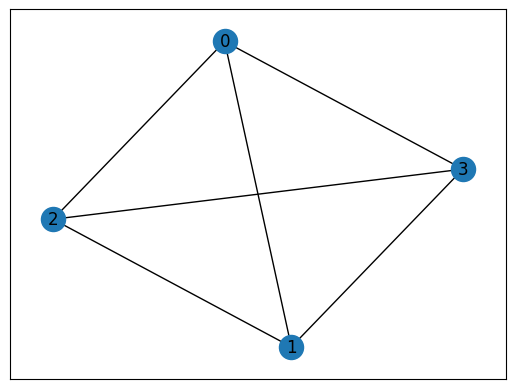

In [18]:
tiny_graph, tiny_jobs, tiny_truck_location = generate_problem(4, 2) # 4 locations, 2 parcels
tiny_problem = get_planning_task(tiny_graph, tiny_jobs, tiny_truck_location)
nx.draw_networkx(tiny_graph, with_labels=True) # uncomment if you do not have matplotlib
print("Jobs:")
for parcel_id, (origin, destination) in enumerate(tiny_jobs):
    print('Parcel', parcel_id, 'from location', origin,
          'to location', destination) 
print('The truck is at location', tiny_truck_location)

In [19]:
with Compiler(name = "fast-downward-reachability-grounder") as grounder:
    grounder_result = grounder.compile(
        tiny_problem, 
        CompilationKind.GROUNDING
    )
    ground_problem = grounder_result.problem


Generating Datalog program... [0.000s CPU, 0.001s wall-clock]
Normalizing Datalog program...
Normalizing Datalog program: [0.000s CPU, 0.001s wall-clock]
Preparing model... [0.000s CPU, 0.001s wall-clock]
Generated 14 rules.
Computing model... [0.000s CPU, 0.001s wall-clock]
59 relevant atoms
30 auxiliary atoms
89 final queue length
98 total queue pushes


If we now have a look at the actions of the ground problem, we see that the actions do not have parameters anymore but instead we have actions for the truckmovements between each two actions and loading and unloading each parcel at their respective origin and goal locations.

In [20]:
print(ground_problem.actions)

[action move_loc2_loc0 {
    preconditions = [
      truck_at(loc2)
    ]
    effects = [
      truck_at(loc2) := false
      truck_at(loc0) := true
    ]
  }, action move_loc2_loc1 {
    preconditions = [
      truck_at(loc2)
    ]
    effects = [
      truck_at(loc2) := false
      truck_at(loc1) := true
    ]
  }, action move_loc2_loc3 {
    preconditions = [
      truck_at(loc2)
    ]
    effects = [
      truck_at(loc2) := false
      truck_at(loc3) := true
    ]
  }, action move_loc0_loc1 {
    preconditions = [
      truck_at(loc0)
    ]
    effects = [
      truck_at(loc0) := false
      truck_at(loc1) := true
    ]
  }, action move_loc0_loc2 {
    preconditions = [
      truck_at(loc0)
    ]
    effects = [
      truck_at(loc0) := false
      truck_at(loc2) := true
    ]
  }, action move_loc0_loc3 {
    preconditions = [
      truck_at(loc0)
    ]
    effects = [
      truck_at(loc0) := false
      truck_at(loc3) := true
    ]
  }, action move_loc1_loc0 {
    preconditions = [

We can now solve the ground problem and translate the plan back to one for the original problem:

In [21]:
with OneshotPlanner(name = "fast-downward") as planner:
    ground_plan = planner.solve(ground_problem).plan
print("We found the following plan for the ground instance:")
print(ground_plan)

# Translate plan back to one for the original problem
plan = ground_plan.replace_action_instances(grounder_result.map_back_action_instance)

print("\nThis corresponds to the following plan for the original problem:")
print(plan)

# Verify that it is indeed a plan for the original problem, using the plan validator operation mode of the UP
print("\nCan we verify this?")
from unified_planning.engines import ValidationResultStatus
with PlanValidator(problem_kind = tiny_problem.kind) as validator:
    if validator.validate(tiny_problem, plan).status == ValidationResultStatus.VALID:
        print("Yes!!")
    else:
        print("No?!? This should not happen.")

We found the following plan for the ground instance:
SequentialPlan:
    move_loc2_loc0
    load_parcel1_loc0
    load_parcel0_loc0
    move_loc0_loc1
    unload_parcel0_loc1
    move_loc1_loc3
    unload_parcel1_loc3

This corresponds to the following plan for the original problem:
SequentialPlan:
    move(loc2, loc0)
    load(parcel1, loc0)
    load(parcel0, loc0)
    move(loc0, loc1)
    unload(parcel0, loc1)
    move(loc1, loc3)
    unload(parcel1, loc3)

Can we verify this?
Yes!!
